### Matt Frysinger
### Portfolio Piece 1

This portfolio piece expands on Lab 1, my n-gram experiment with the text of Frankenstein. See MF_README.md for details.

In [61]:
# Imports & reproducibility

import re
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [62]:
# Load text; normalize; tokenize

def normalize_text(text):
    text = text.lower()
    text = re.sub(r"\s+"," ", text) # collapse whitespace into single spaces
    return text

def tokenize(text):
    return re.findall(r"[a-z']+", text)

with open("Frankenstein_Full-Text.txt", "r", encoding="utf-8") as f:
    raw_text = f.read() # reading source text

cleaned = normalize_text(raw_text)
tokens = tokenize(cleaned)

print("Total tokens:", len(tokens)) # Sanity check
print("Unique vocabulary size:", len(set(tokens))) # Sanity check

Total tokens: 75289
Unique vocabulary size: 6972


In [63]:
# Train/test split
# trains on earlier chapters, tests on later

def train_test_split(tokens, frac=0.8):
    cut = int(len(tokens)*frac)
    return tokens[:cut], tokens[cut:]

train_tokens, test_tokens = train_test_split(tokens)
print("Train size:", len(train_tokens)) # First 80%
print("Test size:", len(test_tokens)) # Last 20%

Train size: 60231
Test size: 15058


In [64]:
# N-Gram model
# Example n=3
    # context = ("i", "am")
    # Counter might store: "happy:" 4, "sad:" 3, ...

def build_ngram_models(tokens, max_n):
    models = {n: defaultdict(Counter) for n in range(1, max_n + 1)}

    for i in range(len(tokens)): # go through every position, tokens[i] = next word
        for n in range(1, max_n + 1):
            start = i - (n - 1)
            if start < 0:
                continue
            context = tuple(tokens[start:i])
            next_word = tokens[i]
            models[n][context][next_word] += 1
    return models

MAX_N = 10
models = build_ngram_models(train_tokens, MAX_N)

In [65]:
# Hard backoff, with minimum freq. threshold
# Logic:
# * highest order context first (max_n)
# * if it exists and passes freq. threshold, use it
# * otherwise fall back to lower n and so forth
# * unigram if nothing
# * freq. threshold keeps from memorizing and displaying every unique long sentence (biggest problem from Lab 1)

def next_word_distr(history, models, max_n, min_count=1):
    for n in range(max_n, 0, -1):
        context_len = n-1
        context = tuple(history[-context_len:]) if context_len > 0 else ()

        if context in models[n]:
            total = sum(models[n][context].values()) # context sum

            if total >= min_count: # freq. threshold
                probs = {w: c/total for w, c in models[n][context].items()}
                return probs, n # distribution, n

    uni = models[1][()] # unigram fallback
    total = sum(uni.values())
    return {w: c/total for w, c in uni.items()}, 1

In [66]:
# Generation & usage tracking
# * one token at a time
# * see which n was used

def generate_text(prompt, models, max_n, length=50, min_count=1):
    history = tokenize(normalize_text(prompt))
    usage = Counter()

    for _ in range(length):
        probs, used_n = next_word_distr(history, models, max_n, min_count)
        words = list(probs.keys())
        weights = list(probs.values())
        next_word = random.choices(words, weights=weights)[0] # sampled by learned probs

        history.append(next_word)
        usage[used_n] +=1
    return " ".join(history), usage

In [68]:
# Eval statistic
# * how well the model predicts next token in sequence 
# * lower test value = better

def perplexity(tokens, models, max_n, min_count=1):
    log_prob = 0
    count = 0

    for i in range(1, len(tokens)):
        history = tokens[:i]
        target = tokens[i]
        probs, _ = next_word_distr(history, models, max_n, min_count)
        p = probs.get(target, 1e-12)
        log_prob += math.log(p)
        count += 1
    
    avg_log = log_prob / count
    return math.exp(-avg_log)

In [71]:
# Run the test
# Experimentationa cross min_count vals
# * looking for: n-usage distr; perplextity (train vs. test); lower test perplexity = better
# * interpreting results: [(n=10, X times), (n=y, z times), etc.]

for min_count in [1,2,5]:
    print("\nmin_count =", min_count)

    text, usage = generate_text(
        prompt = "i am",
        models = models,
        max_n = MAX_N,
        length = 100,
        min_count = min_count
    )

    print("Top n usage:", usage.most_common(3))

    train_ppl = perplexity(train_tokens, models, MAX_N, min_count)
    test_ppl = perplexity(test_tokens, models, MAX_N, min_count)

    print("Train Perplexity:", round(train_ppl,2))
    print("Test Perplexity:", round(test_ppl,2))


min_count = 1
Top n usage: [(10, 93), (3, 1), (4, 1)]
Train Perplexity: 1.0
Test Perplexity: 134771835.83

min_count = 2
Top n usage: [(3, 44), (2, 37), (4, 10)]
Train Perplexity: 10.48
Test Perplexity: 15753949.64

min_count = 5
Top n usage: [(2, 55), (3, 26), (1, 16)]
Train Perplexity: 34.12
Test Perplexity: 1292889.73


## Visualizations

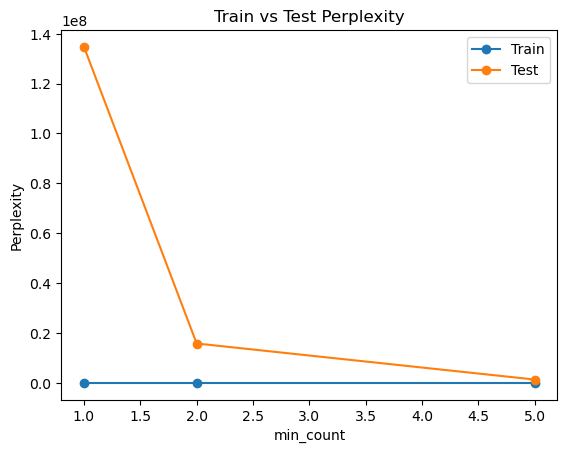

In [72]:
# Train vs Test Perplexity by min_count
# * shows extreme overfitting at min_count = 1
# * improvement as min_count increases

min_counts = [1,2,5]
train_ppls = []
test_ppls = []

for mc in min_counts:
    train_ppls.append(perplexity(train_tokens, models, MAX_N, mc))
    test_ppls.append(perplexity(test_tokens, models, MAX_N, mc))

plt.figure()
plt.plot(min_counts, train_ppls, marker='o')
plt.plot(min_counts, test_ppls, marker='o')
plt.xlabel("min_count")
plt.ylabel("Perplexity")
plt.title("Train vs Test Perplexity")
plt.legend(["Train", "Test"])
plt.show()

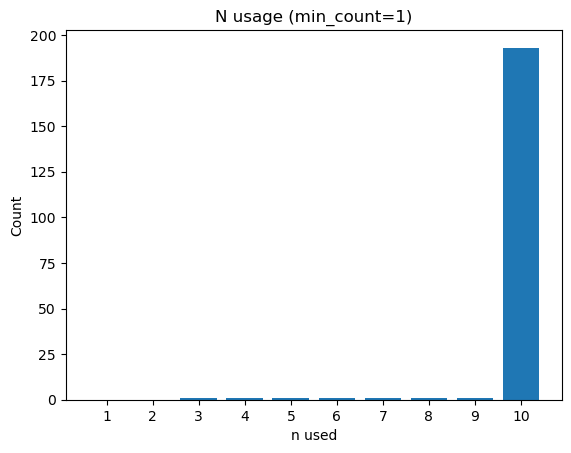

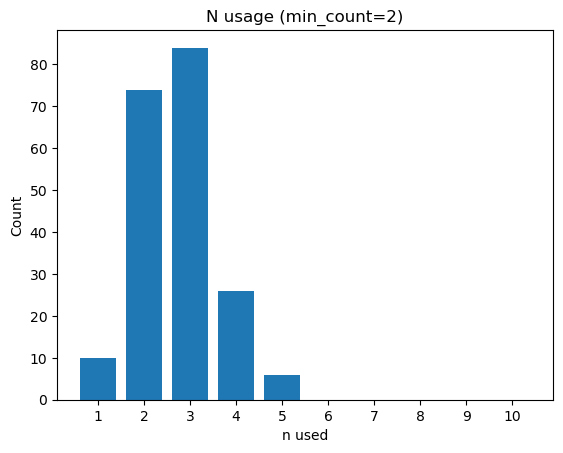

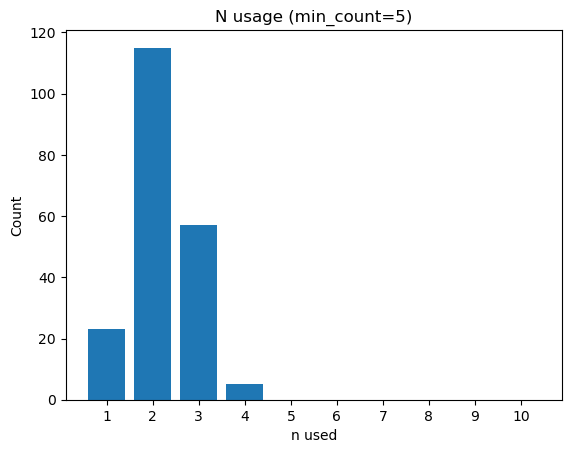

In [73]:
def plot_usage(usage, title):
    ns = list(range(1, MAX_N + 1))
    counts = [usage.get(n, 0) for n in ns]

    plt.figure()
    plt.bar(ns, counts)
    plt.xticks(ns)
    plt.xlabel("n used")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

for mc in [1,2,5]:
    _, usage = generate_text("i am", models, MAX_N, 200, mc)
    plot_usage(usage, f"N usage (min_count={mc})")